# Provenance

One aspect of data provenance is keeping track of the processing steps applied to data.

Next, we will learn how this can be done working with `xarray` objects.

In [1]:
import h5rdmtoolbox as h5tbx
import numpy as np

For the example, let's assume a 3D-velocity field with time, y- and x-dimension:

In [2]:
cv = h5tbx.conventions.from_zenodo('https://zenodo.org/record/8301535', force_download=True)

h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

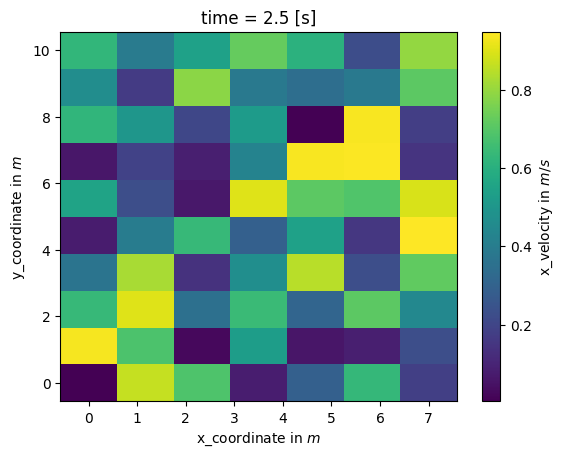

In [3]:
with h5tbx.File(data_type='experimental', contact=h5tbx.__author_orcid__) as h5:
    h5.create_dataset('time', data=np.linspace(0, 5, 5), standard_name='time', units='s', make_scale=True)
    h5.create_dataset('y', data=np.linspace(0, 10, 10), standard_name='y_coordinate', units='m', make_scale=True)
    h5.create_dataset('x', data=np.linspace(0, 7, 7), standard_name='x_coordinate', units='m', make_scale=True)
    h5.create_dataset('u', data=np.random.rand(5, 10, 7), standard_name='x_velocity', units='m/s', attach_scale=('time', 'y', 'x'))
    u = h5.u[:]

# plot t=2.5 s:
u.sel(time=2.5).plot()

Let's say we want to compute the time average of the above data, then we could do the following:

In [4]:
u.mean(dim='time', keep_attrs=True)

<xarray.DataArray 'u' (y: 10, x: 7)>
0.4926 0.8251 0.6593 0.4959 0.2481 0.5511 ... 0.6132 0.4395 0.6122 0.4385 0.6523
Coordinates:
  * y        (y) float64 0.0 1.111 2.222 3.333 4.444 ... 6.667 7.778 8.889 10.0
  * x        (x) float64 0.0 1.167 2.333 3.5 4.667 5.833 7.0
Attributes:
    standard_name:  x_velocity
    units:          m/s
    PROVENANCE:     {'HDF': {'root': {'__h5rdmtoolbox_version__': '0.8rc2', '...

This leaves us with two issues:
- the standard name of the new array is incorrect, it should be "arithmetic_mean_of_x_velocity"
- information about the original data is lost, e.g. what were the time bounds?

Provenance features must be implemented by the user. With standard names concept, we got such an example. Some of the transformations applicable to standard names can perform mathematical operations:

In [5]:
from h5rdmtoolbox.conventions.standard_names import accessor

In [6]:
from typing import Dict
class HDF5Provenance:

    def __init__(self, data: Dict):
        self._data = data

    @property
    def file(self):
        return self._data['HDF']

    def get_processing_history(self):
        return self._data['SNT_TRANSFORMATION_HISTORY']#_TRANSFORMATION_HISTORY']

In [7]:
import xarray as xr

In [8]:
u

<xarray.DataArray 'u' (time: 5, y: 10, x: 7)>
0.7085 0.6734 0.8667 0.9857 0.3957 0.3618 ... 0.947 0.4376 0.08031 0.7291 0.2978
Coordinates:
  * time     (time) float64 0.0 1.25 2.5 3.75 5.0
  * y        (y) float64 0.0 1.111 2.222 3.333 4.444 ... 6.667 7.778 8.889 10.0
  * x        (x) float64 0.0 1.167 2.333 3.5 4.667 5.833 7.0
Attributes:
    standard_name:  x_velocity
    units:          m/s
    PROVENANCE:     {'HDF': {'root': {'__h5rdmtoolbox_version__': '0.8rc2', '...

In [23]:
u_mean = u.snt.arithmetic_mean_of(dim=('time')).snt.arithmetic_mean_of(dim=('x'))
prov = u_mean.snt.get_provenance()

print(f'HDF source file: {HDF5Provenance(prov).file["filename"]}')
print('Transformation history:')

out = ''
for item in HDF5Provenance(prov).get_processing_history():
    for s in item['parent']['dims_shape'], ' --', item['name'], f'{tuple(item["bounds"].keys())}' ,' --> ':
        out += str(s)

out += str({d: len(u[d]) for d in u_mean.dims})
print(out)


HDF source file: C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_2\tmp0.hdf
Transformation history:
{'time': 5, 'y': 10, 'x': 7} --arithmetic_mean_of('time',) --> {'y': 10, 'x': 7} --arithmetic_mean_of('x',) --> {'y': 10}


In [10]:
print(f'HDF source file: {HDF5Provenance(prov).file["filename"]}')
print('Transformation history:')
for item in HDF5Provenance(prov).get_processing_history():
    # print(item)
    print(item['name'])
    print(item['parent'])
    print(item['bounds'])
    print(item['len'])
    # dims = []
    # for dim_name, dim_data in v.items():
    #     _from = xr.DataArray.from_dict(v[dim_name]['bounds'][0])
    #     _to = xr.DataArray.from_dict(v[dim_name]['bounds'][1])
    #     _len = HDF5Provenance(prov).get_processing_history()['arithmetic_mean_of'][dim_name]['len']
    #     _from_str = f'{h5tbx.get_ureg().Quantity(_from.data[()], _from.units)}'
    #     _to_str = f'{h5tbx.get_ureg().Quantity(_to.data[()], _to.units)}'
    #     dims.append(f'{_len} data points of "{dim_name}" in bounds [{_from_str}, {_to_str}]')
    # print(f'  > "{k}" over\n     -', '\n     - '.join(dims))

HDF source file: C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_2\tmp0.hdf
Transformation history:
arithmetic_mean_of
{'dims_shape': {'time': 5, 'y': 10, 'x': 7}, 'coord_bounds': {'time': [{'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 0.0, 'coords': {'time': {'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 0.0}}, 'name': 'time'}, {'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 5.0, 'coords': {'time': {'dims': (), 'attrs': {'standard_name': 'time', 'units': 's'}, 'data': 5.0}}, 'name': 'time'}], 'y': [{'dims': (), 'attrs': {'standard_name': 'y_coordinate', 'units': 'm'}, 'data': 0.0, 'coords': {'y': {'dims': (), 'attrs': {'standard_name': 'y_coordinate', 'units': 'm'}, 'data': 0.0}}, 'name': 'y'}, {'dims': (), 'attrs': {'standard_name': 'y_coordinate', 'units': 'm'}, 'data': 10.0, 'coords': {'y': {'dims': (), 'attrs': {'standard_name': 'y_coordinate', 'units': 'm'}, 'data': 10.0}}, 'name': 'y'}], 'x':

In [11]:
u_mean

<xarray.DataArray 'u' (y: 10)>
0.5514 0.4661 0.4333 0.5743 0.4615 0.4568 0.4581 0.5081 0.4837 0.488
Coordinates:
  * y        (y) float64 0.0 1.111 2.222 3.333 4.444 ... 6.667 7.778 8.889 10.0
Attributes:
    standard_name:  arithmetic_mean_of_arithmetic_mean_of_x_velocity
    units:          m/s
    PROVENANCE:     {'HDF': {'root': {'__h5rdmtoolbox_version__': '0.8rc2', '...

In [12]:
prov

{'HDF': {'root': {'__h5rdmtoolbox_version__': '0.8rc2',
   'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object),
   'data_type': 'experimental',
   'standard_name_table': '10.5281/zenodo.8276716'},
  'group': {'__h5rdmtoolbox_version__': '0.8rc2',
   'contact': array(['https://orcid.org/0000-0001-8729-0482'], dtype=object),
   'data_type': 'experimental',
   'standard_name_table': '10.5281/zenodo.8276716'},
  'filename': 'C:\\Users\\da4323\\AppData\\Local\\h5rdmtoolbox\\h5rdmtoolbox\\tmp\\tmp_2\\tmp0.hdf'},
 'SNT_TRANSFORMATION_HISTORY': [{'parent': {'dims_shape': {'time': 5,
     'y': 10,
     'x': 7},
    'coord_bounds': {'time': [{'dims': (),
       'attrs': {'standard_name': 'time', 'units': 's'},
       'data': 0.0,
       'coords': {'time': {'dims': (),
         'attrs': {'standard_name': 'time', 'units': 's'},
         'data': 0.0}},
       'name': 'time'},
      {'dims': (),
       'attrs': {'standard_name': 'time', 'units': 's'},
       'data': 5.0,
      

In [13]:
u_mean.coords

Coordinates:
  * y        (y) float64 0.0 1.111 2.222 3.333 4.444 ... 6.667 7.778 8.889 10.0

In [14]:
da = xr.DataArray.from_dict(HDF5Provenance(prov).get_processing_history()['arithmetic_mean_of']['time'][0])
da

TypeError: list indices must be integers or slices, not str